# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

import warnings
warnings.filterwarnings("ignore")

C:\Users\hp\Anaconda3\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
# using the SQLite Table to read data.
con = sqlite3.connect('database.sqlite')

#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query("""SELECT * FROM Reviews WHERE Score != 3""", con) 

# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be 0 and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative

In [3]:
print(filtered_data.shape) 
filtered_data.head()

(525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,0,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,1,1350777600,Great taffy,Great taffy at a great price. There was a wid...


#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [4]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [5]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [6]:
#Deduplication of entries
final = sorted_data.drop_duplicates(subset = {"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [7]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [8]:
display = pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)
display

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [9]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [10]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


1    307061
0     57110
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [11]:
# find sentences containing HTML tags
import re
i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1; 

6
I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.


In [12]:
stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)
print('************************************')
print(sno.stem('tasty'))

{'once', 'that', "weren't", 'both', 'had', 'a', 'o', "doesn't", 'the', "didn't", 'it', 'by', 'of', 'ma', 'their', 'at', "aren't", 'on', 'no', 'only', 'up', 'will', 'while', 'y', 'themselves', 'yours', 'when', 'why', 'yourself', 'being', 'herself', 'itself', 'who', 'were', "won't", 'yourselves', 'me', 'your', 'than', 'have', 'from', 'doesn', "wouldn't", 'do', 'this', 'he', 'an', 'mustn', 'does', "haven't", 'is', "needn't", 'before', 'off', 'wouldn', 'needn', 'be', 'own', 'we', 'which', 'her', 'mightn', 'such', 'weren', 'll', "couldn't", "mightn't", 'whom', 'against', 'each', 'what', 'over', 'through', 'in', 'under', 'very', "hadn't", 'has', "you're", 'theirs', 'because', "you'll", "she's", 're', 'just', 'you', 'don', 'but', 'should', "shouldn't", 'again', 'shouldn', 'isn', 'having', "you've", 'into', 'to', 'did', 'or', 'myself', 'ain', 'its', 'doing', "mustn't", "isn't", 'same', 'they', 'any', 'as', 'until', 'was', 'below', 'now', 'out', 'then', 'haven', 'more', 'too', 'other', 'here', 

In [13]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 1: 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 0:
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

In [14]:
final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 

In [15]:
final.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,b'witti littl book make son laugh loud recit c...
138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,1,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",b'grew read sendak book watch realli rosi movi...
138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,1,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,b'fun way children learn month year learn poem...


In [16]:
# store final table into an SQlLite table for future.
conn = sqlite3.connect('final.sqlite')
c=conn.cursor()
conn.text_factory = str
final.to_sql('Reviews', conn, schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)

In [17]:
con = sqlite3.connect("final.sqlite")
cleaned_data = pd.read_sql_query("select * from Reviews", con)

In [18]:
print(cleaned_data.shape)
cleaned_data.head()

(364171, 12)


,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,b'witti littl book make son laugh loud recit c...
1,138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,1,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",b'grew read sendak book watch realli rosi movi...
2,138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,1,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,b'fun way children learn month year learn poem...
3,138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,1,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,b'great littl book read nice rhythm well good ...
4,138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,1,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,b'book poetri month year goe month cute littl ...


In [19]:
cleaned_data['Score'].value_counts()

1    307061
0     57110
Name: Score, dtype: int64

In [20]:
# To randomly sample 60k points from both class
random_sample_data = final.sample(n=100000) 
random_sample_data.shape

(100000, 11)

In [21]:
# Sort data based on time
final_sorted_time=random_sample_data.sort_values('Time',ascending=True,axis=0)

In [22]:
final_sorted_time.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,b'witti littl book make son laugh loud recit c...
346041,374343,B00004CI84,A1B2IZU1JLZA6,Wes,19,23,0,948240000,WARNING: CLAMSHELL EDITION IS EDITED TV VERSION,"I, myself always enjoyed this movie, it's very...",b'alway enjoy movi funni entertain didnt hesit...
70688,76882,B00002N8SM,A32DW342WBJ6BX,Buttersugar,0,0,1,948672000,A sure death for flies,I bought a few of these after my apartment was...,b'bought apart infest fruit fli hour trap mani...


In [23]:
#data splitting
y_Train=final_sorted_time['Score'][0:70000]
y_train=final_sorted_time['Score'][0:49000]
y_cv=final_sorted_time['Score'][49000:70000]
y_test=final_sorted_time['Score'][70000:100000]

In [24]:
Train_data=final_sorted_time['CleanedText'][0:70000]
train_data=final_sorted_time['CleanedText'][0:49000]
cv_data=final_sorted_time['CleanedText'][49000:70000]
test_data=final_sorted_time['CleanedText'][70000:100000]

# [4] Featurization

##  BAG OF WORDS

## [4.1] Bi-Grams and n-Grams.

In [25]:
count_vector = CountVectorizer(ngram_range=(1,2))
bow_train = count_vector.fit_transform(train_data)
bow_cv  = count_vector.transform(cv_data)

In [26]:
bow_train.shape

(49000, 763027)

In [27]:
bow_cv.shape

(21000, 763027)

## [4.2] TF-IDF

In [28]:
tfidf_vec = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_train = tfidf_vec.fit_transform(train_data)
tf_cv  = tfidf_vec.transform(cv_data)
tf_test = tfidf_vec.transform(test_data)

## [4.3] Word2Vec

In [29]:
# Train your own Word2Vec model using your own text corpus
list_of_sent_train = []
for i in train_data:
    sent = []
    for word in i.split():
        sent.append(word.decode('utf-8'))
    list_of_sent_train.append(sent)

In [30]:
list_of_sent_cv = []
for i in cv_data:
    sent = []
    for word in i.split():
        sent.append(word.decode('utf-8'))
    list_of_sent_cv.append(sent)

In [31]:
list_of_sent_test = []
for i in test_data:
    sent = []
    for word in i.split():
        sent.append(word.decode('utf-8'))
    list_of_sent_test.append(sent)

In [32]:
len(list_of_sent_train)

49000

In [33]:
print(len(list_of_sent_cv))
len(list_of_sent_test)

21000


30000

In [34]:
from gensim.models import Word2Vec
w2v_model = Word2Vec(list_of_sent_train,min_count = 5,size = 50,workers = 4)

In [35]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  9383
sample words  ['littl', 'book', 'make', 'son', 'laugh', 'loud', 'recit', 'car', 'drive', 'along', 'alway', 'sing', 'refrain', 'hes', 'learn', 'india', 'love', 'new', 'word', 'introduc', 'silli', 'classic', 'will', 'bet', 'still', 'abl', 'memori', 'colleg', 'enjoy', 'movi', 'funni', 'entertain', 'didnt', 'hesit', 'pick', 'edit', 'guess', 'market', 'plan', 'famili', 'someth', 'elimin', 'strong', 'element', 'usual', 'televis', 'version', 'warn', 'want', 'uncut']


## [4.3.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.3.1.1] Avg W2v

In [36]:
sent_vectors_train = []
for sent in list_of_sent_train:
    sent_vec = np.zeros(50)
    cnt_word = 0
    for word in sent:
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_word += 1
        except:
            pass
    if cnt_word!=0:
        sent_vec /= cnt_word
    
    sent_vectors_train.append(sent_vec)
print(len(sent_vectors_train))

49000


In [37]:
sent_vectors_cv = []
for sent in list_of_sent_cv:
    sent_vec = np.zeros(50)
    cnt_word = 0
    for word in sent:
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_word += 1
        except:
            pass
    if cnt_word!=0:
        sent_vec /= cnt_word
    sent_vectors_cv.append(sent_vec)
print(len(sent_vectors_cv))

21000


In [38]:
sent_vectors_test = []
for sent in list_of_sent_test:
    sent_vec = np.zeros(50)
    cnt_word = 0
    for word in sent:
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_word += 1
        except:
            pass
    if cnt_word!=0:
        sent_vec /= cnt_word
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))

30000


#### [4.3.1.2] TFIDF weighted W2v

In [39]:
tf_idf_feat = tfidf_vec.get_feature_names()
tfidf_sent_vec_train = []
row = 0
for sent in list_of_sent_train:
    sent_vec = np.zeros(50)
    weight_sum = 0
    for word in sent:
        try:
            vec = w2v_model.wv[word]
            tfidf = tf_train[row,tf_idf_feat.index(word)]
            sent_vec += (vec*tfidf)
            weight_sum += tfidf
        except:
            pass
    if weight_sum !=0:
        sent_vec/= weight_sum
    
    tfidf_sent_vec_train.append(sent_vec)
    row += 1

In [40]:
tf_idf_feat = tfidf_vec.get_feature_names()
tfidf_sent_vec_cv = []
row = 0
for sent in list_of_sent_cv:
    sent_vec = np.zeros(50)
    weight_sum = 0
    for word in sent:
        try:
            vec = w2v_model.wv[word]
            tfidf = tf_cv[row,tf_idf_feat.index(word)]
            sent_vec += (vec*tfidf)
            weight_sum += tfidf
        except:
            pass
    if weight_sum !=0:
        sent_vec/= weight_sum
    tfidf_sent_vec_cv.append(sent_vec)
    row += 1

In [41]:
tf_idf_feat = tfidf_vec.get_feature_names()
tfidf_sent_vec_test = []
row = 0
for sent in list_of_sent_test:
    sent_vec = np.zeros(50)
    weight_sum = 0
    for word in sent:
        try:
            vec = w2v_model.wv[word]
            tfidf = tf_test[row,tf_idf_feat.index(word)]
            sent_vec += (vec*tfidf)
            weight_sum += tfidf
        except:
            pass
    if weight_sum !=0:
        sent_vec/= weight_sum
    tfidf_sent_vec_test.append(sent_vec)
    row += 1

In [42]:
tfw2v_train= np.array(tfidf_sent_vec_train)
tfw2v_train.shape

(49000, 50)

In [43]:
tfw2v_cv= np.array(tfidf_sent_vec_cv)

In [44]:
tfw2v_cv.shape

(21000, 50)

In [45]:
tfw2v_test= np.array(tfidf_sent_vec_test)
tfw2v_test.shape

(30000, 50)

In [149]:
np.save("tfw2v_train", tfw2v_train)
np.save("tfw2v_cv", tfw2v_cv)
np.save("tfw2v_test", tfw2v_test)

# [5] Assignment 7: SVM

<ol>
    <li><strong>Apply SVM on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Procedure</strong>
        <ul>
    <li>You need to work with 2 versions of SVM
        <ul><li>Linear kernel</li>
            <li>RBF kernel</li></ul>
    <li>When you are working with linear kernel, use SGDClassifier’ with hinge loss because it is computationally less expensive.</li>
    <li>When you are working with ‘SGDClassifier’ with hinge loss and trying to find the AUC
        score, you would have to use <a href='https://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html'>CalibratedClassifierCV</a></li>
    <li>Similarly, like kdtree of knn, when you are working with RBF kernel it's better to reduce
the number of dimensions. You can put min_df = 10, max_features = 500 and consider a sample size of 40k points.</li>                
        </ul>
    </li>
    <br>
    <li><strong>Hyper paramter tuning (find best alpha in range [10^-4 to 10^4], and the best penalty among 'l1', 'l2')</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>When you are working on the linear kernel with BOW or TFIDF please print the top 10 best
features for each of the positive and negative classes.</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# Applying SVM

## [5.1] Linear SVM

### [5.1.1] Applying Linear SVM on BOW,<font color='red'> SET 1</font>

In [34]:
# Hyperparameter tuning:
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_auc_score, auc
penalties = ['l1', 'l2']
C = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
cv_scores = []
tr_scores = []
i = 0
for alpha in C:
    for p in penalties:
        m = SGDClassifier(loss='hinge', penalty=p, alpha=alpha, n_jobs=-1)
        clf = CalibratedClassifierCV(base_estimator=m, cv=None)
        clf.fit(bow_train, y_train)
        y_score=clf.predict_proba(bow_cv)[:,1]
        scores = roc_auc_score(y_cv, y_score)
        cv_scores.append(scores)
        y_score=clf.predict_proba(bow_train)[:,1]
        scores = roc_auc_score(y_train, y_score)
        tr_scores.append(scores)
        print("CV ROC_AUC Score : ", cv_scores[i], " Train ROC_AUC Score : ", tr_scores[i], "C : ", alpha, " penalty : ", p)
        i += 1

CV ROC_AUC Score :  0.9340696053174733  Train ROC_AUC Score :  0.99293296273959 C :  1e-05  penalty :  l1
CV ROC_AUC Score :  0.9378926925385017  Train ROC_AUC Score :  0.9990633697214896 C :  1e-05  penalty :  l2
CV ROC_AUC Score :  0.9306012623338092  Train ROC_AUC Score :  0.954923723430882 C :  0.0001  penalty :  l1
CV ROC_AUC Score :  0.9405270879793477  Train ROC_AUC Score :  0.9991228984098507 C :  0.0001  penalty :  l2
CV ROC_AUC Score :  0.9001999438833728  Train ROC_AUC Score :  0.8988542064017053 C :  0.001  penalty :  l1
CV ROC_AUC Score :  0.9457081414106189  Train ROC_AUC Score :  0.9932818648967179 C :  0.001  penalty :  l2
CV ROC_AUC Score :  0.7631182792339892  Train ROC_AUC Score :  0.7568010272385357 C :  0.01  penalty :  l1
CV ROC_AUC Score :  0.9246878354841237  Train ROC_AUC Score :  0.945933256047051 C :  0.01  penalty :  l2
CV ROC_AUC Score :  0.6377108783268208  Train ROC_AUC Score :  0.6294333635051633 C :  0.1  penalty :  l1
CV ROC_AUC Score :  0.773397705264

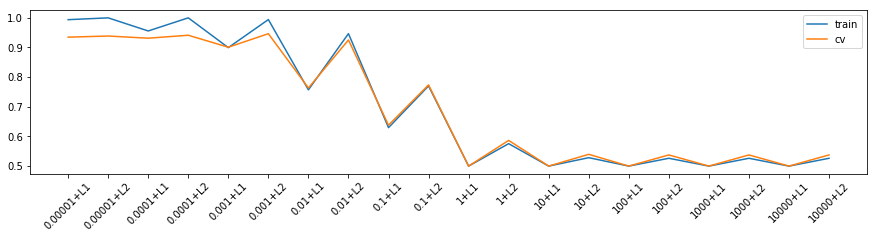

In [35]:
alpha = ['0.00001+L1', '0.00001+L2', '0.0001+L1', '0.0001+L2', '0.001+L1', '0.001+L2', '0.01+L1', '0.01+L2',
         '0.1+L1', '0.1+L2', '1+L1', '1+L2', '10+L1', '10+L2', '100+L1', '100+L2','1000+L1','1000+L2','10000+L1','10000+L2']
plt.figure(figsize=(15,3))
plt.plot(range(len(C)*len(penalties)), tr_scores)
plt.plot(range(len(C)*len(penalties)), cv_scores)
plt.xticks(range(len(C)*len(penalties)), alpha, rotation = 45)
plt.legend(['train', 'cv'])
plt.show()

In [36]:
om = SGDClassifier(loss = 'hinge', penalty='l2', alpha=0.01)
om.fit(bow_train, y_train)

SGDClassifier(alpha=0.01, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)

In [37]:
om = SGDClassifier(loss='hinge', penalty='l2', alpha=0.01)
model = CalibratedClassifierCV(base_estimator=om, cv=None)
model.fit(bow_train, y_train)

CalibratedClassifierCV(base_estimator=SGDClassifier(alpha=0.01, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False),
            cv=None, method='sigmoid')

# Now Lets see result on Test data i.e on unseen data

In [40]:
#count_vect= CountVectorizer(ngram_range=(1,2))
#bow_Train=count_vect.fit_transform(Train_data)
#bows_test=count_vect.transform(test_data)

In [42]:
bow_test= count_vector.transform(test_data)

In [43]:
y_pred= model.predict(bow_test)

In [66]:
def plot_confusion_matrix(y_actual, y_predicted):
    cm = confusion_matrix( y_actual,  y_predicted)
    labels = ["negative", "positive"]
    df = pd.DataFrame(data=cm, index=labels, columns=labels)
    print("Confusion Matrix : ")
    plt.figure(figsize=(6,4))
    sns.heatmap(df, annot=True)
    plt.show()

Confusion Matrix : 


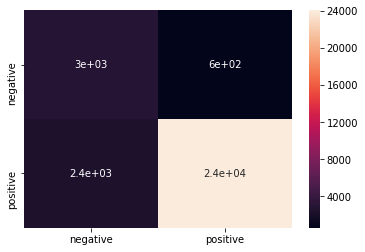

In [60]:
from sklearn.metrics import confusion_matrix
plot_confusion_matrix(y_test, y_pred)

In [61]:
cm = confusion_matrix( y_test, y_pred)
cm

array([[ 2971,  2356],
       [  603, 24070]], dtype=int64)

In [65]:
y_pred = model.predict_proba(bow_test)[:,1]
score= roc_auc_score(y_test, y_pred)
print('AUC score on test data is:', score)

AUC score on test data is: 0.9188230030781217


### [5.1.2] Applying Linear SVM on TFIDF,<font color='red'> SET 2</font>

In [74]:
# Hyperparameter tuning :
penalties = ['l1', 'l2']
C = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100,1000,10000]
cv_scores = []
tr_scores = []
i = 0
for alpha in C:
    for p in penalties:
        m = SGDClassifier(loss='hinge', penalty=p, alpha=alpha)
        clf = CalibratedClassifierCV(base_estimator=m, cv=None)
        clf.fit(tf_train, y_train)
        scores = roc_auc_score(y_cv, clf.predict_proba(tf_cv)[:,1])
        cv_scores.append(scores)
        scores = roc_auc_score(y_train, clf.predict_proba(tf_train)[:,1])
        tr_scores.append(scores)
        print("CV ROC_AUC Score : ", cv_scores[i], " Train ROC_AUC Score : ", tr_scores[i], "C : ", alpha, " penalty : ", p)
        i += 1

CV ROC_AUC Score :  0.9502145031567496  Train ROC_AUC Score :  0.9858447231511255 C :  1e-05  penalty :  l1
CV ROC_AUC Score :  0.9501128659232287  Train ROC_AUC Score :  0.9939886160368129 C :  1e-05  penalty :  l2
CV ROC_AUC Score :  0.9307157422727145  Train ROC_AUC Score :  0.9318142750000837 C :  0.0001  penalty :  l1
CV ROC_AUC Score :  0.9483856798218253  Train ROC_AUC Score :  0.9721120189047119 C :  0.0001  penalty :  l2
CV ROC_AUC Score :  0.6863053089093476  Train ROC_AUC Score :  0.6841148736155714 C :  0.001  penalty :  l1
CV ROC_AUC Score :  0.9436367660717306  Train ROC_AUC Score :  0.9629828619771665 C :  0.001  penalty :  l2
CV ROC_AUC Score :  0.5  Train ROC_AUC Score :  0.5 C :  0.01  penalty :  l1
CV ROC_AUC Score :  0.9440153734441  Train ROC_AUC Score :  0.963068018305288 C :  0.01  penalty :  l2
CV ROC_AUC Score :  0.5  Train ROC_AUC Score :  0.5 C :  0.1  penalty :  l1
CV ROC_AUC Score :  0.6398555706828111  Train ROC_AUC Score :  0.6318081084244247 C :  0.1  pe

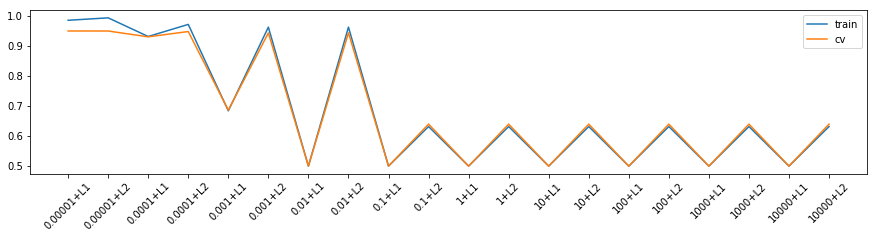

In [76]:
alpha = ['0.00001+L1', '0.00001+L2', '0.0001+L1', '0.0001+L2', '0.001+L1', '0.001+L2', '0.01+L1', '0.01+L2',
         '0.1+L1', '0.1+L2', '1+L1', '1+L2', '10+L1', '10+L2', '100+L1', '100+L2','1000+L1','1000+L2','10000+L1','10000+L2']
plt.figure(figsize=(15,3))
plt.plot(range(len(C)*len(penalties)), tr_scores)
plt.plot(range(len(C)*len(penalties)), cv_scores)
plt.xticks(range(len(C)*len(penalties)), alpha, rotation = 45)
plt.legend(['train', 'cv'])
plt.show()

In [77]:
m = SGDClassifier(loss = 'hinge', penalty='l2', alpha=1e-05)
m.fit(tf_train, y_train)

SGDClassifier(alpha=1e-05, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)

In [78]:
m = SGDClassifier(loss='hinge', penalty='l2', alpha=1e-05)
model = CalibratedClassifierCV(base_estimator=m, cv=None)
model.fit(tf_train, y_train)

CalibratedClassifierCV(base_estimator=SGDClassifier(alpha=1e-05, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False),
            cv=None, method='sigmoid')

# Result on unseen data

Confusion Matrix : 


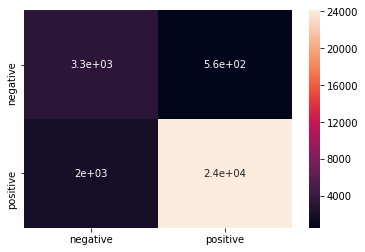

In [79]:
y_pred = model.predict(tf_test)
plot_confusion_matrix(y_test, y_pred)

In [80]:
cm = confusion_matrix( y_test, y_pred)
cm

array([[ 3298,  2029],
       [  558, 24115]], dtype=int64)

In [81]:
y_pred = model.predict_proba(tf_test)[:,1]
score=roc_auc_score(y_test, y_pred)
print("ROC score on unseen data of tfidf is: ", score)

ROC score on unseen data of tfidf is:  0.9475795327037592


### [5.1.3]  Applying Linear SVM on AVG W2V,<font color='red'> SET 3</font>

In [100]:
# Hyperparameter tuning :
penalties = ['l1', 'l2']
C = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100,1000,10000]
cv_scores = []
tr_scores = []
i = 0
for alpha in C:
    for p in penalties:
        m = SGDClassifier(loss='hinge', penalty=p, alpha=alpha)
        clf = CalibratedClassifierCV(base_estimator=m, cv=None)
        clf.fit(sent_vectors_train, y_train)
        scores = roc_auc_score(y_cv, clf.predict_proba(sent_vectors_cv)[:,1])
        cv_scores.append(scores)
        scores = roc_auc_score(y_train, clf.predict_proba(sent_vectors_train)[:,1])
        tr_scores.append(scores)
        print("CV ROC_AUC Score : ", cv_scores[i], " Train ROC_AUC Score : ", tr_scores[i], "C : ", alpha, " penalty : ", p)
        i += 1

CV ROC_AUC Score :  0.8831708399779344  Train ROC_AUC Score :  0.8845104793030371 C :  1e-05  penalty :  l1
CV ROC_AUC Score :  0.8700143876165776  Train ROC_AUC Score :  0.8684516931050181 C :  1e-05  penalty :  l2
CV ROC_AUC Score :  0.8916731053743661  Train ROC_AUC Score :  0.8915973239562903 C :  0.0001  penalty :  l1
CV ROC_AUC Score :  0.8932563711336121  Train ROC_AUC Score :  0.8924553843372222 C :  0.0001  penalty :  l2
CV ROC_AUC Score :  0.8948230707495489  Train ROC_AUC Score :  0.892965937496238 C :  0.001  penalty :  l1
CV ROC_AUC Score :  0.8960573746443091  Train ROC_AUC Score :  0.8953929392310149 C :  0.001  penalty :  l2
CV ROC_AUC Score :  0.8382824923128361  Train ROC_AUC Score :  0.832267437913289 C :  0.01  penalty :  l1
CV ROC_AUC Score :  0.8945131418741552  Train ROC_AUC Score :  0.8934637884989063 C :  0.01  penalty :  l2
CV ROC_AUC Score :  0.5  Train ROC_AUC Score :  0.5 C :  0.1  penalty :  l1
CV ROC_AUC Score :  0.8941052045394893  Train ROC_AUC Score : 

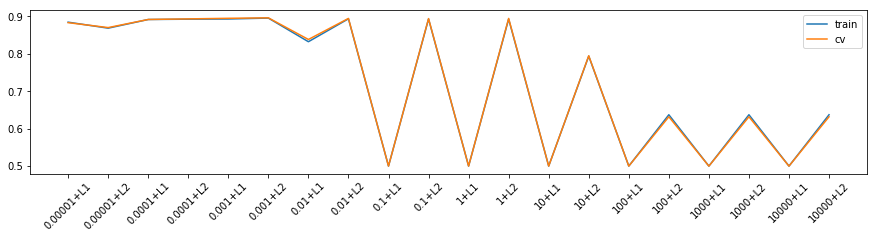

In [101]:
alpha = ['0.00001+L1', '0.00001+L2', '0.0001+L1', '0.0001+L2', '0.001+L1', '0.001+L2', '0.01+L1', '0.01+L2',
         '0.1+L1', '0.1+L2', '1+L1', '1+L2', '10+L1', '10+L2', '100+L1', '100+L2','1000+L1','1000+L2','10000+L1','10000+L2']
plt.figure(figsize=(15,3))
plt.plot(range(len(C)*len(penalties)), tr_scores)
plt.plot(range(len(C)*len(penalties)), cv_scores)
plt.xticks(range(len(C)*len(penalties)), alpha, rotation = 45)
plt.legend(['train', 'cv'])
plt.show()

In [102]:
m = SGDClassifier(loss='hinge', penalty='l2', alpha=0.01)
model = CalibratedClassifierCV(base_estimator=m, cv=None)
model.fit(sent_vectors_train, y_train)

CalibratedClassifierCV(base_estimator=SGDClassifier(alpha=0.01, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False),
            cv=None, method='sigmoid')

# Result on unseen data

In [104]:
np.isnan(sent_vectors_train)

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [105]:
np.isnan(sent_vectors_cv)

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [106]:
np.isnan(sent_vectors_test)

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [108]:
np.where(np.isnan(sent_vectors_test))

(array([27826, 27826, 27826, 27826, 27826, 27826, 27826, 27826, 27826,
        27826, 27826, 27826, 27826, 27826, 27826, 27826, 27826, 27826,
        27826, 27826, 27826, 27826, 27826, 27826, 27826, 27826, 27826,
        27826, 27826, 27826, 27826, 27826, 27826, 27826, 27826, 27826,
        27826, 27826, 27826, 27826, 27826, 27826, 27826, 27826, 27826,
        27826, 27826, 27826, 27826, 27826], dtype=int64),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49],
       dtype=int64))

In [109]:
np.nan_to_num(sent_vectors_test)

array([[-0.36055383, -0.0882455 , -0.14607091, ...,  0.26498536,
         0.34033219, -0.52324785],
       [-0.52845144, -0.08533141, -0.12703028, ...,  0.27026715,
         0.18334248,  0.3804581 ],
       [-0.66585199, -0.27462157,  0.53919998, ..., -0.21668261,
         0.60342923, -0.65822748],
       ...,
       [-0.41859362, -0.07878885,  0.50618823, ...,  0.25732372,
         0.2389253 , -0.2138205 ],
       [-0.49944421,  0.75401115, -0.71848958, ...,  0.27402208,
         0.91889334, -0.50573799],
       [-0.53424546, -0.59956576, -0.0218214 , ...,  0.34130721,
         0.70372312, -0.591834  ]])

In [117]:
from pandas import DataFrame
#avg= np.median(sent_vectors_test)
df = DataFrame(sent_vectors_test)

df2=df.fillna(0)

In [118]:
df2.shape

(30000, 50)

Confusion Matrix : 


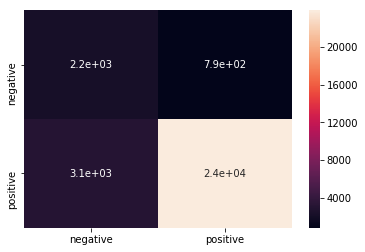

In [119]:
y_pred = model.predict(df2)
plot_confusion_matrix(y_test, y_pred)

In [120]:
y_pred = model.predict_proba(df2)[:,1]
roc_auc_score(y_test, y_pred)

0.8894813010950646

### [5.1.4]  Applying Linear SVM on TFIDF W2V,<font color='red'> SET 4</font>

In [150]:
# Hyperparameter tuning :
penalties = ['l1', 'l2']
C = [0.00001, 0.00005, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
cv_scores = []
tr_scores = []
i = 0
for alpha in C:
    for p in penalties:
        m = SGDClassifier(loss='hinge', penalty=p, alpha=alpha)
        clf = CalibratedClassifierCV(base_estimator=m, cv=None)
        clf.fit(tfw2v_train, y_train)
        y_score=clf.predict_proba(tfw2v_cv)[:,1]
        scores = roc_auc_score(y_cv, y_score)
        cv_scores.append(scores)
        scores = roc_auc_score(y_train, clf.predict_proba(tfw2v_train)[:,1])
        tr_scores.append(scores)
        print("CV ROC_AUC Score : ", cv_scores[i], " Train ROC_AUC Score : ", tr_scores[i], "alpha : ", alpha, " penalty : ", p)
        i += 1

CV ROC_AUC Score :  0.8451099442866401  Train ROC_AUC Score :  0.8488966770251944 alpha :  1e-05  penalty :  l1
CV ROC_AUC Score :  0.8278466030034513  Train ROC_AUC Score :  0.8356456652092823 alpha :  1e-05  penalty :  l2
CV ROC_AUC Score :  0.8543768555263802  Train ROC_AUC Score :  0.8608091935328439 alpha :  5e-05  penalty :  l1
CV ROC_AUC Score :  0.857429522419861  Train ROC_AUC Score :  0.8616383347766448 alpha :  5e-05  penalty :  l2
CV ROC_AUC Score :  0.8576266279706803  Train ROC_AUC Score :  0.8611572848409326 alpha :  0.0001  penalty :  l1
CV ROC_AUC Score :  0.8519942654638321  Train ROC_AUC Score :  0.8554930198541472 alpha :  0.0001  penalty :  l2
CV ROC_AUC Score :  0.8590384262580376  Train ROC_AUC Score :  0.8611205629996995 alpha :  0.001  penalty :  l1
CV ROC_AUC Score :  0.8649828002411526  Train ROC_AUC Score :  0.8681690847284472 alpha :  0.001  penalty :  l2
CV ROC_AUC Score :  0.8014900267715187  Train ROC_AUC Score :  0.7906719060708075 alpha :  0.01  penalt

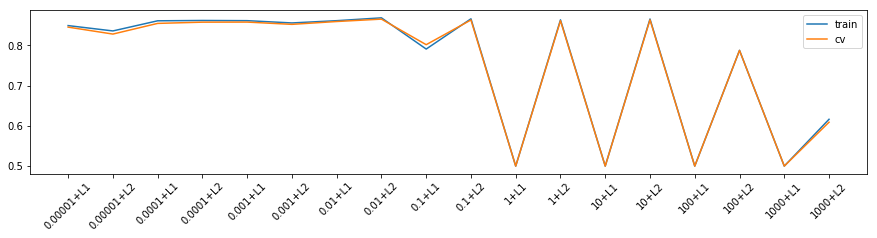

In [151]:
alpha = ['0.00001+L1', '0.00001+L2', '0.0001+L1', '0.0001+L2', '0.001+L1', '0.001+L2', '0.01+L1', '0.01+L2',
         '0.1+L1', '0.1+L2', '1+L1', '1+L2', '10+L1', '10+L2', '100+L1', '100+L2','1000+L1','1000+L2','10000+L1','10000+L2']
plt.figure(figsize=(15,3))
plt.plot(range(len(C)*len(penalties)), tr_scores)
plt.plot(range(len(C)*len(penalties)), cv_scores)
plt.xticks(range(len(C)*len(penalties)), alpha, rotation = 45)
plt.legend(['train', 'cv'])
plt.show()

In [152]:
m = SGDClassifier(loss='hinge', penalty='l2', alpha=0.001)
model = CalibratedClassifierCV(base_estimator=m, cv=None)
model.fit(tfw2v_train, y_train)

CalibratedClassifierCV(base_estimator=SGDClassifier(alpha=0.001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False),
            cv=None, method='sigmoid')

# Result on Test data(unseen data)

Confusion Matrix : 


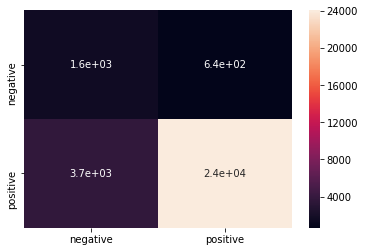

In [153]:
y_pred = model.predict(tfw2v_test)
plot_confusion_matrix(y_test, y_pred)

In [154]:
y_pred = model.predict_proba(tfw2v_test)[:,1]
roc_auc_score(y_test, y_pred)

0.8581394099815258

## [5.2] RBF SVM

### [5.2.1] Applying RBF SVM on BOW,<font color='red'> SET 1</font>

In [46]:
#data splitting for RBF kernel
y_train=final_sorted_time['Score'][0:13000]
y_cv=final_sorted_time['Score'][13000:16000]
y_test=final_sorted_time['Score'][16000:20000]

In [47]:
X_train=final_sorted_time['CleanedText'][0:13000]
X_cv=final_sorted_time['CleanedText'][13000:16000]
X_test=final_sorted_time['CleanedText'][16000:20000]

In [48]:
print(X_train.shape, "   ", y_train.shape)
print(X_cv.shape, "   ", y_cv.shape)
print(X_test.shape, "   ", y_test.shape)

(13000,)     (13000,)
(3000,)     (3000,)
(4000,)     (4000,)


In [49]:
cnt_vec = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=300)
bow_train = cnt_vec.fit_transform(X_train)
bow_cv  = cnt_vec.transform(X_cv)
bow_test = cnt_vec.transform(X_test)

In [50]:
print(bow_train.shape)
print(bow_cv.shape)
print(bow_test.shape)

(13000, 300)
(3000, 300)
(4000, 300)


In [53]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
def svc_grid_rbf(X, y):
    C = [10**-4, 10**-2, 10**0, 10**2, 10**4]
    gamma = [10**-4, 10**-2, 10**0, 10**2, 10**4]
    tuned_parameters_grid = dict(C = C, gamma = gamma)
    model_svc_grid = GridSearchCV(SVC(kernel = "rbf", class_weight = "balanced", probability=True), tuned_parameters_grid, cv = 3, scoring = "roc_auc")
    model_svc_grid.fit(X, y)
    print("\n**********GridSearchCV**********\n")
    print("\nOptimal C:", model_svc_grid.best_estimator_.C)
    print("\nOptimal Gamma:", model_svc_grid.best_estimator_.gamma)
    print("\nBest kernel:", model_svc_grid.best_estimator_.kernel)
    print("\nBest Score:", model_svc_grid.best_score_)
    df_gridsearch = pd.DataFrame(model_svc_grid.cv_results_)
    max_scores = df_gridsearch.groupby(['param_C','param_gamma']).max()
    max_scores = max_scores.unstack()[['mean_test_score', 'mean_train_score']]
    sns.heatmap(max_scores.mean_test_score, annot=True, fmt='.4g')
    plt.show()
    return model_svc_grid.best_estimator_.C, model_svc_grid.best_estimator_.gamma


**********GridSearchCV**********


Optimal C: 1

Optimal Gamma: 0.01

Best kernel: rbf

Best Score: 0.8634786393955619


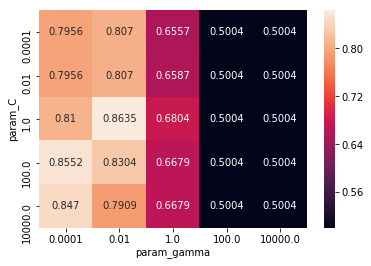

In [54]:
# To choose c and gamma, call the rbf utility function
optimal_C_bow_grid_rbf, optimal_gamma_bow_grid_rbf = svc_grid_rbf(bow_train, y_train)

In [55]:
y_cv.shape

(3000,)

In [57]:
model = SVC(C=1, kernel='rbf', probability=True, gamma=0.01)
model.fit(bow_train, y_train)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

# Result on Test data

In [58]:
pred = model.predict(bow_test)
pred_prob = model.predict_proba(bow_test)[:,1]

In [59]:
# Train accuracy
train_acc_bow_rbf = model.score(bow_train, y_train)
print("Train accuracy:", train_acc_bow_rbf)

Train accuracy: 0.8927692307692308


In [61]:
# auc_roc score
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, pred_prob)

0.8636865553513071

In [63]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, pred)
cm

array([[  11,  533],
       [   4, 3452]], dtype=int64)

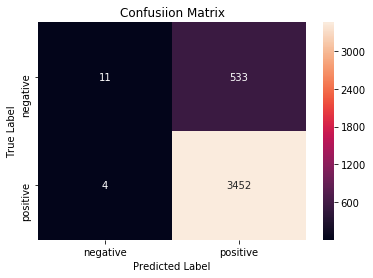

In [64]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [68]:
# To show main classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))

             precision    recall  f1-score   support

          0       0.73      0.02      0.04       544
          1       0.87      1.00      0.93      3456

avg / total       0.85      0.87      0.81      4000



### [5.2.2] Applying RBF SVM on TFIDF,<font color='red'> SET 2</font>

In [69]:
tfidf_vec = TfidfVectorizer(ngram_range=(1,2), min_df=10, max_features=300)
tf_train = tfidf_vec.fit_transform(X_train)
tf_cv  = tfidf_vec.transform(X_cv)
tf_test = tfidf_vec.transform(X_test)

In [70]:
print(tf_train.shape)
print(tf_cv.shape)
print(tf_test.shape)

(13000, 300)
(3000, 300)
(4000, 300)


In [71]:
y_train.shape

(13000,)


**********GridSearchCV**********


Optimal C: 1

Optimal Gamma: 1

Best kernel: rbf

Best Score: 0.8676664299612968


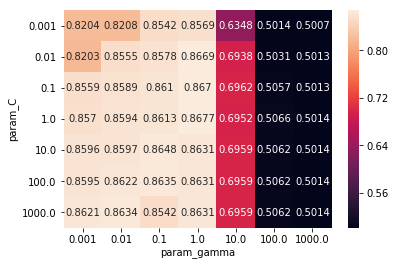

SyntaxError: 'return' outside function (<ipython-input-72-9bd196bc1879>, line 16)

In [72]:
C = [ 0.001, 0.01, 0.1, 1, 10, 100,1000]
gamma = [0.001, 0.01, 0.1, 1, 10, 100,1000]
tuned_parameters_grid = dict(C = C, gamma = gamma)
model_svc_grid = GridSearchCV(SVC(kernel = "rbf", probability=True), tuned_parameters_grid, cv = 3, scoring = "roc_auc")
model_svc_grid.fit(tf_train, y_train)
print("\n**********GridSearchCV**********\n")
print("\nOptimal C:", model_svc_grid.best_estimator_.C)
print("\nOptimal Gamma:", model_svc_grid.best_estimator_.gamma)
print("\nBest kernel:", model_svc_grid.best_estimator_.kernel)
print("\nBest Score:", model_svc_grid.best_score_)
df_gridsearch = pd.DataFrame(model_svc_grid.cv_results_)
max_scores = df_gridsearch.groupby(['param_C','param_gamma']).max()
max_scores = max_scores.unstack()[['mean_test_score', 'mean_train_score']]
sns.heatmap(max_scores.mean_test_score, annot=True, fmt='.4g')
plt.show()
#return model_svc_grid.best_estimator_.C, model_svc_grid.best_estimator_.gamma

In [73]:
model_svc_grid.score(tf_cv, y_cv)

0.8648937594565509

In [76]:
model = SVC(C=1, kernel='rbf', probability=True, gamma= 1)
model.fit(tf_train, y_train)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [77]:
pred = model.predict(tf_test)
pred_prob = model.predict_proba(tf_test)[:,1]

In [78]:
# Train accuracy
train_acc_tf_rbf = model.score(tf_train, y_train)
print("Train accuracy:", train_acc_tf_rbf)

Train accuracy: 0.9375384615384615


# Result on test data

In [79]:
# auc_roc score
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, pred_prob)

0.8764877153118191

In [80]:
cm = confusion_matrix(y_test, pred)
cm

array([[  73,  471],
       [  15, 3441]], dtype=int64)

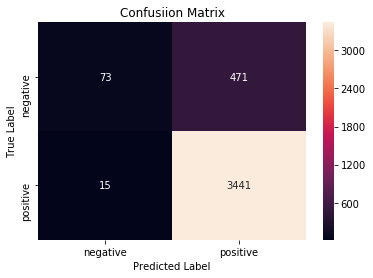

In [81]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [82]:
# To show main classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))

             precision    recall  f1-score   support

          0       0.83      0.13      0.23       544
          1       0.88      1.00      0.93      3456

avg / total       0.87      0.88      0.84      4000



### [5.2.3]  Applying RBF SVM on AVG W2V,<font color='red'> SET 3</font>

In [83]:
avg_w2v = np.array(sent_vectors_train)

In [84]:
avg_w2v.shape

(49000, 50)

In [85]:
avgw2v_train = avg_w2v[0:13000]
avgw2v_cv = avg_w2v[13000:16000]
avgw2v_test = avg_w2v[16000:20000]

In [86]:
avgw2v_train.shape

(13000, 50)

In [87]:
y_train.shape

(13000,)


**********GridSearchCV**********


Optimal C: 10

Optimal Gamma: 0.01

Best kernel: rbf

Best Score: 0.894978506474535


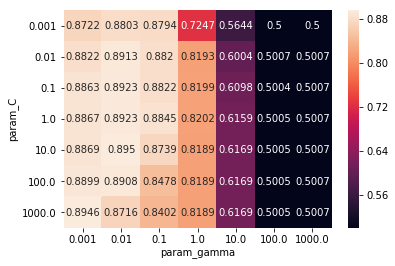

In [88]:
#hyperparameter tuning
C = [ 0.001, 0.01, 0.1, 1, 10, 100,1000]
gamma = [0.001, 0.01, 0.1, 1, 10, 100,1000]
tuned_parameters_grid = dict(C = C, gamma = gamma)
model_svc_grid = GridSearchCV(SVC(kernel = "rbf", probability=True), tuned_parameters_grid, cv = 3, scoring = "roc_auc")
model_svc_grid.fit(avgw2v_train, y_train)
print("\n**********GridSearchCV**********\n")
print("\nOptimal C:", model_svc_grid.best_estimator_.C)
print("\nOptimal Gamma:", model_svc_grid.best_estimator_.gamma)
print("\nBest kernel:", model_svc_grid.best_estimator_.kernel)
print("\nBest Score:", model_svc_grid.best_score_)
df_gridsearch = pd.DataFrame(model_svc_grid.cv_results_)
max_scores = df_gridsearch.groupby(['param_C','param_gamma']).max()
max_scores = max_scores.unstack()[['mean_test_score', 'mean_train_score']]
sns.heatmap(max_scores.mean_test_score, annot=True, fmt='.4g')
plt.show()

In [89]:
model_svc_grid.score(avgw2v_cv, y_cv)

0.8978778065130533

In [90]:
model = SVC(C=10, kernel='rbf', probability=True, gamma= 0.01)
model.fit(avgw2v_train, y_train)

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [91]:
# Train accuracy
train_acc_avgw2v_rbf = model.score(avgw2v_train, y_train)
print("Train accuracy:", train_acc_avgw2v_rbf)

Train accuracy: 0.9126923076923077


# Result on unseen data

In [93]:
pred = model.predict(avgw2v_test)
pred_prob = model.predict_proba(avgw2v_test)[:,1]

In [94]:
# auc_roc score
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, pred_prob)

0.8915451814406318

In [95]:
cm = confusion_matrix(y_test, pred)
cm

array([[ 141,  403],
       [  37, 3419]], dtype=int64)

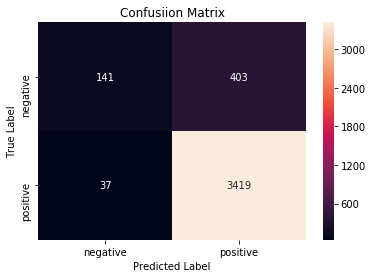

In [96]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [97]:
# To show main classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))

             precision    recall  f1-score   support

          0       0.79      0.26      0.39       544
          1       0.89      0.99      0.94      3456

avg / total       0.88      0.89      0.86      4000



### [5.2.4]  Applying RBF SVM on TFIDF W2V,<font color='red'> SET 4</font>

In [98]:
tfw2v_train.shape

(49000, 50)

In [99]:
tfrbf_train = tfw2v_train[0:13000]
tfrbf_cv = tfw2v_train[13000:16000]
tfrbf_test = tfw2v_train[16000:2000]

In [100]:
y_train.shape

(13000,)


**********GridSearchCV**********


Optimal C: 1000

Optimal Gamma: 0.001

Best kernel: rbf

Best Score: 0.875945460503103


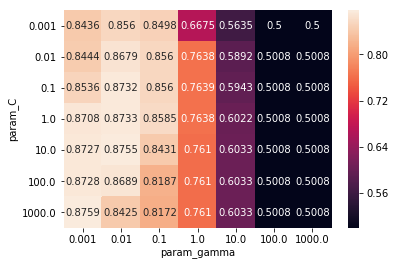

In [101]:
C = [ 0.001, 0.01, 0.1, 1, 10, 100,1000]
gamma = [0.001, 0.01, 0.1, 1, 10, 100,1000]
tuned_parameters_grid = dict(C = C, gamma = gamma)
model_svc_grid = GridSearchCV(SVC(kernel = "rbf", probability=True), tuned_parameters_grid, cv = 3, scoring = "roc_auc")
model_svc_grid.fit(tfrbf_train, y_train)
print("\n**********GridSearchCV**********\n")
print("\nOptimal C:", model_svc_grid.best_estimator_.C)
print("\nOptimal Gamma:", model_svc_grid.best_estimator_.gamma)
print("\nBest kernel:", model_svc_grid.best_estimator_.kernel)
print("\nBest Score:", model_svc_grid.best_score_)
df_gridsearch = pd.DataFrame(model_svc_grid.cv_results_)
max_scores = df_gridsearch.groupby(['param_C','param_gamma']).max()
max_scores = max_scores.unstack()[['mean_test_score', 'mean_train_score']]
sns.heatmap(max_scores.mean_test_score, annot=True, fmt='.4g')
plt.show()

In [102]:
model_svc_grid.score(tfrbf_cv, y_cv)

0.8708191097075679

In [103]:
model = SVC(C=1000, kernel='rbf', probability=True, gamma= 0.001)
model.fit(tfrbf_train, y_train)

SVC(C=1000, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [104]:
# Train accuracy
train_acc_rbf = model.score(tfrbf_train, y_train)
print("Train accuracy:", train_acc_rbf)

Train accuracy: 0.9045384615384615


# Result on test data

In [105]:
y_test.shape

(4000,)

In [106]:
print(tfrbf_train.shape)
print(tfrbf_cv.shape)

(13000, 50)
(3000, 50)


In [107]:
tfw2v_train.shape

(49000, 50)

In [108]:
tfw2v_test_new = tfw2v_train[20000:24000]
y_test_new=final_sorted_time['Score'][20000:24000]

In [109]:
print(tfw2v_test_new.shape)
print(y_test_new.shape)

(4000, 50)
(4000,)


In [110]:
pred = model.predict(tfw2v_test_new)
pred_prob = model.predict_proba(tfw2v_test_new)[:,1]

In [111]:
# auc_roc score
roc_auc_score(y_test_new, pred_prob)

0.8913441676229963

In [112]:
cm = confusion_matrix(y_test_new, pred)
cm

array([[ 100,  495],
       [  26, 3379]], dtype=int64)

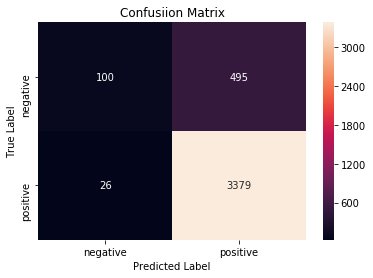

In [113]:
# plot confusion matrix to describe the performance of classifier.
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [114]:
# To show main classification report
from sklearn.metrics import classification_report
print(classification_report(y_test_new, pred))

             precision    recall  f1-score   support

          0       0.79      0.17      0.28       595
          1       0.87      0.99      0.93      3405

avg / total       0.86      0.87      0.83      4000



# [6] Conclusions

In [120]:
# Creating table using PrettyTable library
from prettytable import PrettyTable

# Names of models
names= ['Linear SVM with BOW','Linear SVM with TFIDF', 'Linear SVM with AVG W2V','Linear SVM with TFIDF W2V',\
       'RBF Kernel SVM with BOW','RBF Kernel SVM with TFIDF','RBF Kernel SVM with AVG W2V','RBF Kernel SVM with TFIDF W2v']

optimal_alpha = [0.01, 1e-05, 0.01, 0.001,'Not Applicable','Not Applicable','Not Applicable','Not Applicable']
values_of_C=['Not Applicable','Not Applicable','Not Applicable','Not Applicable',1,1,10,1000]
gammas=['Not Applicable','Not Applicable','Not Applicable','Not Applicable',0.01,1,0.01,0.001]
#training_value=[0.94593,0.99398, 0.89346, 0.86816, 0.93066, 0.93237, 0.91101, 0.89509 ]
#cv_value=[0.92468, 0.95011, 0.89451, 0.86498, 0.86680, 0.86274, 0.89668, 0.87736]
test_value=[0.91882, 0.94757,0.88948,0.85813,0.86368,0.87648,0.89154,0.89134]
pen=['L2','L2','L2','L2', 'Not Applicable','Not Applicable','Not Applicable','Not Applicable']



numbering = [1,2,3,4,5,6,7,8]

# Initializing prettytable
ptable = PrettyTable()

# Adding columns
ptable.add_column("S.NO.",numbering)
ptable.add_column("MODEL",names)
ptable.add_column("Best Alpha",optimal_alpha)
ptable.add_column("Best C", values_of_C)
ptable.add_column("gamma",gammas)
#ptable.add_column("Training's AUC",training_value)
#ptable.add_column("CV's AUC",cv_value)
ptable.add_column("Testing's AUC",test_value)
ptable.add_column("Penalty",pen)




# Printing the Table
ptable.align = "c"
#from prettytable import MSWORD_FRIENDLY
#ptable.set_style(MSWORD_FRIENDLY)

print(ptable)


+-------+-------------------------------+----------------+----------------+----------------+---------------+----------------+
| S.NO. |             MODEL             |   Best Alpha   |     Best C     |     gamma      | Testing's AUC |    Penalty     |
+-------+-------------------------------+----------------+----------------+----------------+---------------+----------------+
|   1   |      Linear SVM with BOW      |      0.01      | Not Applicable | Not Applicable |    0.91882    |       L2       |
|   2   |     Linear SVM with TFIDF     |     1e-05      | Not Applicable | Not Applicable |    0.94757    |       L2       |
|   3   |    Linear SVM with AVG W2V    |      0.01      | Not Applicable | Not Applicable |    0.88948    |       L2       |
|   4   |   Linear SVM with TFIDF W2V   |     0.001      | Not Applicable | Not Applicable |    0.85813    |       L2       |
|   5   |    RBF Kernel SVM with BOW    | Not Applicable |       1        |      0.01      |    0.86368    | Not Appli

From above table we can see unseen data i.e testing data's AUC value and Linear SVM with TFIDF showing pretty well among all.